# Development of a Reader for Siemens Trend CSV files

When complete this code will be put in a `ddc_reader.py` module.

In [176]:
import csv
import string
import datetime
import pandas as pd
import numpy as np

# import matplotlib pyplot commands
from matplotlib.pyplot import *
 
# Show Plots in the Notebook
%matplotlib inline
 
rcParams['figure.figsize']= (10, 8)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

# 'style' the plot like fivethirtyeight.com website
style.use('bmh')


In [9]:
df1 = pd.DataFrame({'a':[1,2,3]}, index=[0,2,4])
df2 = pd.DataFrame({'b':[4,5,6]}, index=[0,1,3])
pd.concat([df1, df2], axis=1)

,a,b
0,1.0,4.0
1,NaN,5.0
2,2.0,NaN
3,NaN,6.0
4,3.0,NaN


In [69]:
def clean_string(s):
    """Function that "cleans" a string by first stripping leading and trailing
    whitespace and then substituting an underscore for all other whitepace
    and punctuation. After that substitution is made, any consecutive occurrences
    of the underscore character are reduced to one occurrence. 
    Finally, the string is converted to lower case.
    Returns the cleaned string.

    Input Parameters:
    -----------------
    s:  The string to clean.
    """
    to_sub = string.whitespace + string.punctuation
    trans_table = str.maketrans(to_sub, len(to_sub) * '_')
    fixed = str.translate(s.strip(), trans_table)

    while True:
        new_fixed = fixed.replace('_' * 2, '_')
        if new_fixed == fixed:
            break
        fixed = new_fixed

    return fixed.lower()


In [188]:
reader = None

In [178]:
file_name = 'data/siemens_sample.csv'
reader = csv.reader(open(file_name))
include_location = False   # if True include location in point ID

# For running in the notebook, this controls how many rows are shown
# for each execution of the cell below.
num_rows_to_show = 30000

data_dict = {}

In [179]:
# repeatedly execute this cell to step through chunks of the data
row_ct = 0
for row in reader:
    #print(row)
    f1 = row[0]
    if '/' in f1:
        # this is a row with a data point in it.
        # create a date/time string and parse into a Python datetime
        ts = '{} {}'.format(row[0], row[1])
        ts = datetime.datetime.strptime(ts, '%m/%d/%Y %H:%M:%S')
        
        # get the value, which is usually a number, but sometimes a string.
        # first try to convert to a number, and if it errors, just return it as a string
        try:
            val = float(row[2])
        except:
            val = row[2]
            
        #print(pt_id, ts, val)
        tstamps, vals = data_dict.get(pt_id, ([], []))
        tstamps.append(ts)
        vals.append(val)
        data_dict[pt_id] = (tstamps, vals)
        
    elif f1.startswith('Point'):
        pt_id = clean_string(row[1])

    elif f1.startswith('Trend L'):
        if include_location:
            pt_id = '{}_{}'.format(clean_string(row[1]), pt_id)
    
    row_ct += 1
    if row_ct == num_rows_to_show: break


In [180]:
df_final = pd.DataFrame()
for pt_id in data_dict.keys():
    tstamps, vals = data_dict[pt_id]
    df = pd.DataFrame(vals, index=tstamps, columns=[pt_id])
    df_final = pd.concat([df_final, df], )


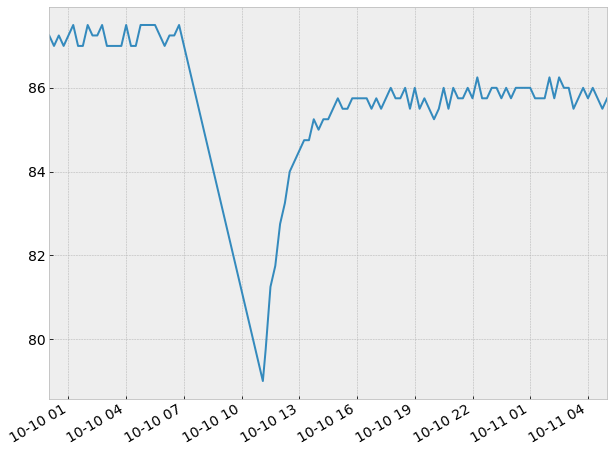

In [185]:
df_final.bh_100w_tec_room_temp.dropna().plot()

In [187]:
df_final.to_csv('test.csv')